# 09.01 SVMs in Action

The support vector machine was, for a long time, one of the most advanced ML techniques.
It fits a surface between the classes (or through a regressed function)
in a way to contain as big margins towards the data points as possible.
For classification the SVM attempts to have as big margins
(distances from the fitted surface) as possible form the classes;
for regression the SVM attempt to fit as many data points within the margins.

![Tony Blair](sl-tony-blair.svg)

<div style="text-align:right;"><sup>sl-tony-blair.svg</sup></div>

SVMs are therefore often called *max-margin* classifiers (or regressors).
The technique works very well with high dimensionality but becomes considerably
slow when faced with too many (millions) samples.
In other words the SVMs were replaced by newer techniques in big data processing.
That said, SVMs are some of the best binary classifiers when not faces with millions of samples.
Let's try to find good ways of classifying two classes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')

To classify two classes we want something that separates them.
The simple (perhaps naive) approach is to:

1. find the center of each class
2. draw a line between the two centers
3. find the middle point between the centers
4. find the perpendicular line that passes through the middle point
5. use this last line as the decision function between the two classes

This, let's call it *mean distance separator*, works.
In practice it performs a very simple algorithm of finding the closest class center,
we can say that it does.

$$
\min_{c} p \cdot c
$$

This is very fast and very easy to code.
We could even say that it is a linear form of Naive Bayes.
Yet, this is not very accurate when classes are close or even interleaved with each other.
Let's do some algebra and try this algorithm out.

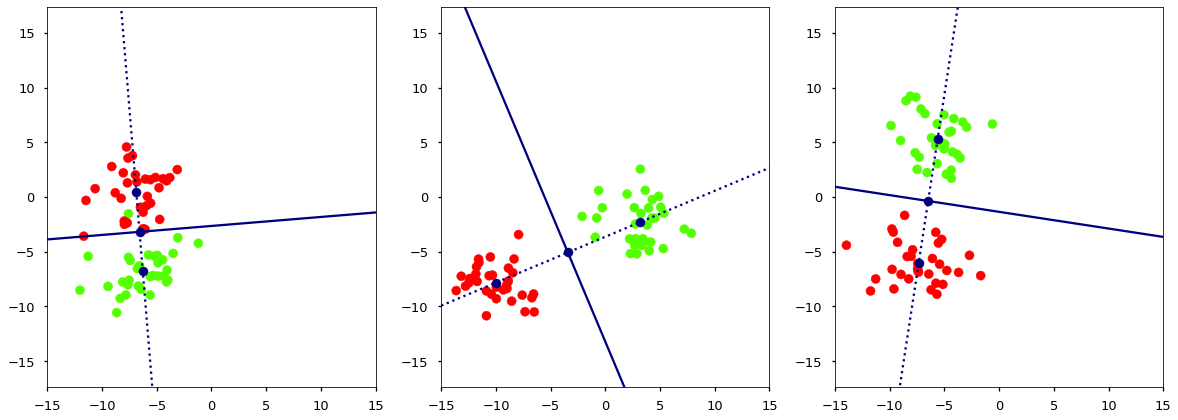

In [2]:
from sklearn.datasets import make_blobs

blob_range = (-15, 15)
blobs = []
n_blob = 3
for i in range(n_blob):
    blobs.append(make_blobs(64, centers=2, cluster_std=2.2))

def naive_separation(blobs, blob_num, ax):
    X, y = blobs[blob_num]
    center0 = X[y == 0, :].mean(axis=0)
    center1 = X[y == 1, :].mean(axis=0)
    incline = (center1[1] - center0[1]) / (center1[0] - center0[0])
    intercept = center0[1] - incline*center0[0]
    middle = (center1 + center0)/2
    invinc = -1/incline
    invinter = middle[1] - invinc*middle[0]

    x_fun = np.linspace(*blob_range, 10)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='prism')
    ax.scatter(center0[0], center0[1], c='navy')
    ax.scatter(center1[0], center1[1], c='navy')
    ax.scatter(middle[0], middle[1], c='navy')
    ax.plot(x_fun, incline*x_fun + intercept, color='navy', linestyle=':')
    ax.plot(x_fun, invinc*x_fun + invinter, color='navy', linestyle='-')
    ax.axis('equal')
    ax.set(xlim=blob_range, ylim=blob_range)

fig, axi = plt.subplots(1, n_blob, figsize=(20, 7))
for i in range(n_blob):
    naive_separation(blobs, i, axi.flat[i])

Sometimes it gets it right, sometimes not quite.
And in higher dimensional space this becomes worse,
because the algorithm does not have a way to tune the slope in specific dimensions.

Instead let's try a **Hard margin** SVM.
This attempt to build a margin between the decision (hyper)plane and the closest samples of each class.
We want a big margin therefore we attempt to fit a (hyper)plane through the current dimensions.
The slope of this (hyper)plane is $w$, which is a vector since we have a slope in each dimension.
This algorithms attempts to minimize the following.

$$
\min_{w, b} \frac{1}{2} w^T \cdot w \\
\texttt{subject to } t^i (w^T \cdot x^i + b) \ge 1, \texttt{ for i as every data point}
$$

This is a form of *quadratic programming* (QP),
which attempts to solve a convex problem with *constraints*.
Several QP procedures exist in `scipy` but `SVC` (Support Vector Classifier) already does this for us.
We will try to fit such a (hyper)plane - here a line- on the blobs above.

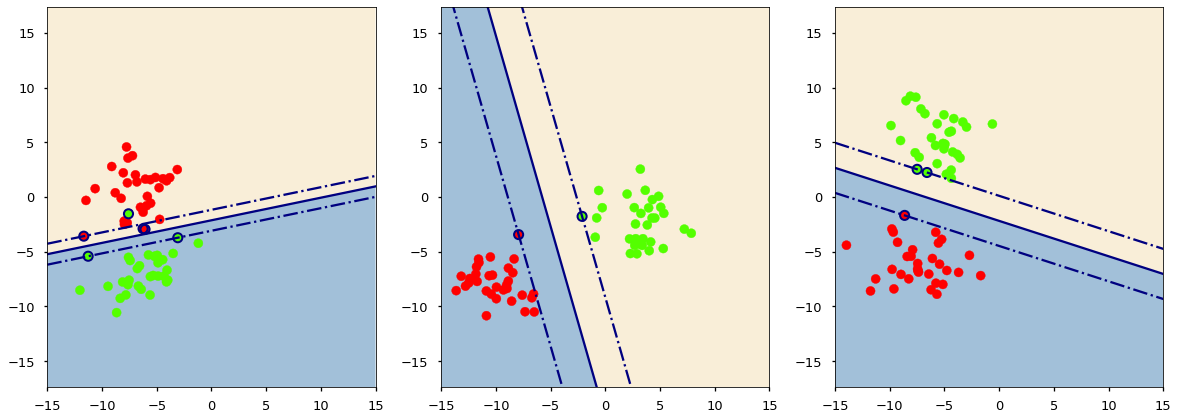

In [3]:
from sklearn.svm import SVC

def svc_separation(blobs, blob_num, ax, svm_C=200):
    X, y = blobs[blob_num]
    model = SVC(C=svm_C, kernel='linear')
    model.fit(X, y)

    incline = - model.coef_[0][0] / model.coef_[0][1]
    x_decision = np.linspace(*blob_range, 128)
    y_decision = incline*x_decision - model.intercept_[0] / model.coef_[0][1]

    margin = 1 / np.sqrt(np.sum(model.coef_[0] ** 2))
    y_up = y_decision + np.sqrt(1 + incline ** 2) * margin
    y_down = y_decision - np.sqrt(1 + incline ** 2) * margin

    ax.fill_between(x_decision, -20, y_decision, facecolor='steelblue', alpha=0.5)
    ax.fill_between(x_decision, 20, y_decision, facecolor='wheat', alpha=0.5)
    ax.plot(x_decision, y_decision, color='navy')
    ax.plot(x_decision, y_up, color='navy', linestyle='-.')
    ax.plot(x_decision, y_down, color='navy', linestyle='-.')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='prism')
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
           facecolor='none', edgecolors='navy', linewidths=2)
    ax.axis('equal')
    ax.set(xlim=blob_range, ylim=blob_range)

fig, axi = plt.subplots(1, n_blob, figsize=(20, 7))
for i in range(n_blob):
    svc_separation(blobs, i, axi.flat[i])

That's better with the margins we often get a decision function that would generalize better.
Yet, if the margin is small, we often see that we could find a better function.
Enter **Soft margin SVM**.
If we could allow some points to be inside the margin,
we would make for bigger margins.
We add an extra parameter to the minimization problem.

$$
\min_{w, b} \frac{1}{2} w^T \cdot w + C \sum \zeta^i\\
\texttt{subject to } t^i (w^T \cdot x^i + b) \ge 1 - \zeta^i, \texttt{ for i as every data point}
$$

This translates into a model hyperparameter the $C$ in SVMs.
The smaller the parameter the more points we can allow within the margin.
The $C$ hyperparameter is an *inverse regularization*,
it works in a similar way to model regularization
but the smaller its value the more regularized the model is.
Let's try again with a small $C$.

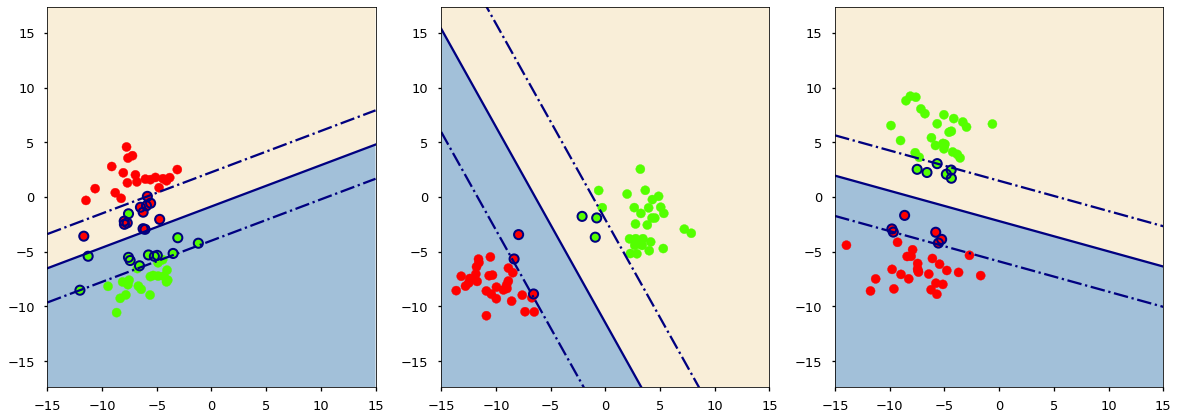

In [4]:
fig, axi = plt.subplots(1, n_blob, figsize=(20, 7))
for i in range(n_blob):
    svc_separation(blobs, i, axi.flat[i], svm_C=0.01)

We got better margins alright.
We  have been marking the *support vectors* in the graphs above.
The support vectors are the points within or on the border of the margins.
A trained SVM keeps track of the support vectors only and classifies based on that alone.
This also means that the smaller $C$ is the model is likely better
but also uses more memory.

## Kernels

But what if a line clearly won't do?
The real power of SVMs is the fact that they work well in very high dimensions,
therefore we can throw our data into a very high dimensional space and fit the hyperplane there.
Here is a blob that cannot be easily classified.

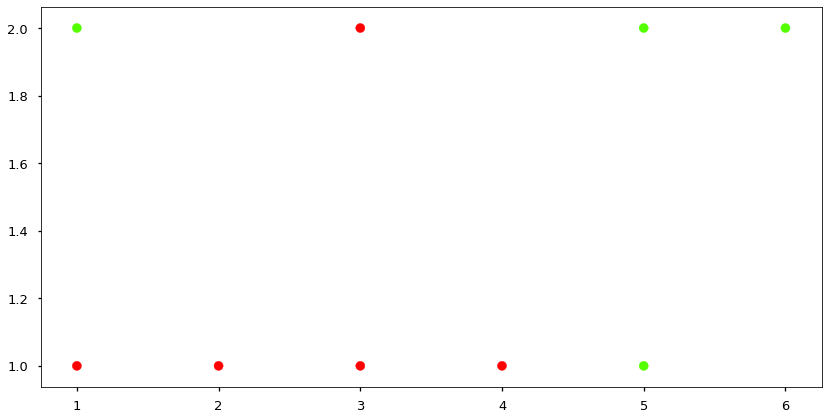

In [5]:
X = np.array([[1, 1], [1, 2], [2, 1], [3, 1], [3, 2], [4, 1], [5, 1], [5, 2], [6, 2]])
y = np.array([0, 1, 0, 0, 0, 0, 1, 1, 1])
fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='prism');

We could add polynomial features to it and then fit the SVM, and that will work.
Yet the SVM itself can do it for us.
It has a `kernel=` parameter which we will set to `poly` (polynomial).

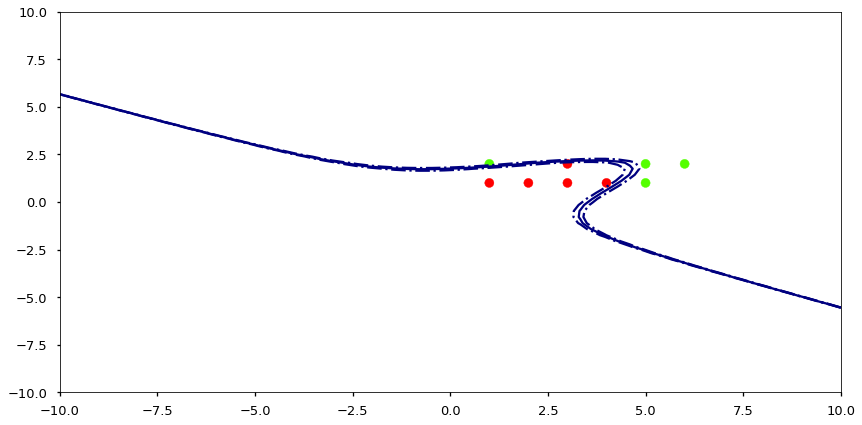

In [6]:
model = SVC(kernel='poly', C=100)
model.fit(X, y)
xg, yg = np.mgrid[-10:10:64j, -10:10:64j]
zg = model.decision_function(np.c_[xg.ravel(), yg.ravel()])

fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='prism');
ax.contour(xg, yg, zg.reshape(xg.shape),
           colors='navy', linestyles=['-.', '-', '-.'], levels=[-.5, 0, .5])
ax.set(xlim=(-10, 10), ylim=(-10, 10));

If you try a pipeline with polynomial features and then compare against a polynomial SVM,
you will find that the SVM is much faster.  Why is that?

During the solution to the SVM QP problem a *kernel trick* is possible.
The kernel trick is a simplification that uses a kernel identity
that simplifies the higher dimensional space to a much simple form.
In other words, instead of actually projecting the data into higher dimension space,
we keep that data in the same dimensions but substitute a kernel expression once
the data in high dimensional space is needed.

All this only works because of a specific way of solving QP problems,
and the fact that a kernel must abide by several properties.
The identity is that we can define a kernel $\kappa$ so that the following holds true
(under specific circumstances).

$$
\kappa(x) \cdot \kappa(y) = \kappa(x, y)
$$

This prevents us from calculating a, possibly huge, dot product.
The typical SVM kernels are as follows.

- Linear Kernel (`linear`)
  $\kappa(x) = x \leftrightarrow \kappa(x, y) = x^T \cdot y$
- Polynomial Kernel (`poly`)
  $\kappa(x) = x^d \leftrightarrow \kappa(x, y) = (\eta x \cdot y + \rho)^d$
- Radial Basis Function Kernel (`rbf`)
  $\kappa(x) = e^{-x^2} \leftrightarrow \kappa(x, y) = e^{-\eta (x - y)^2}$

We can try out how just the kernel itself works.

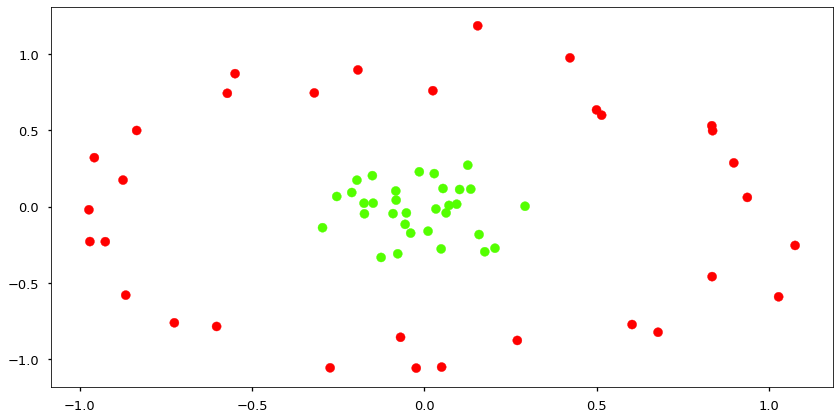

In [7]:
from sklearn.datasets import make_circles
X, y = make_circles(64, factor=0.2, noise=0.1)
fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='prism');

Neither a line or a polynomial will do here.
But we have that Radial Basis Function Kernel, and the equation for a simple
*Gaussian Radial Basis Function* is:

$$
\phi(x) = e^{-x^2}
$$

Let's apply that as a way of throwing the data into higher dimensional space.

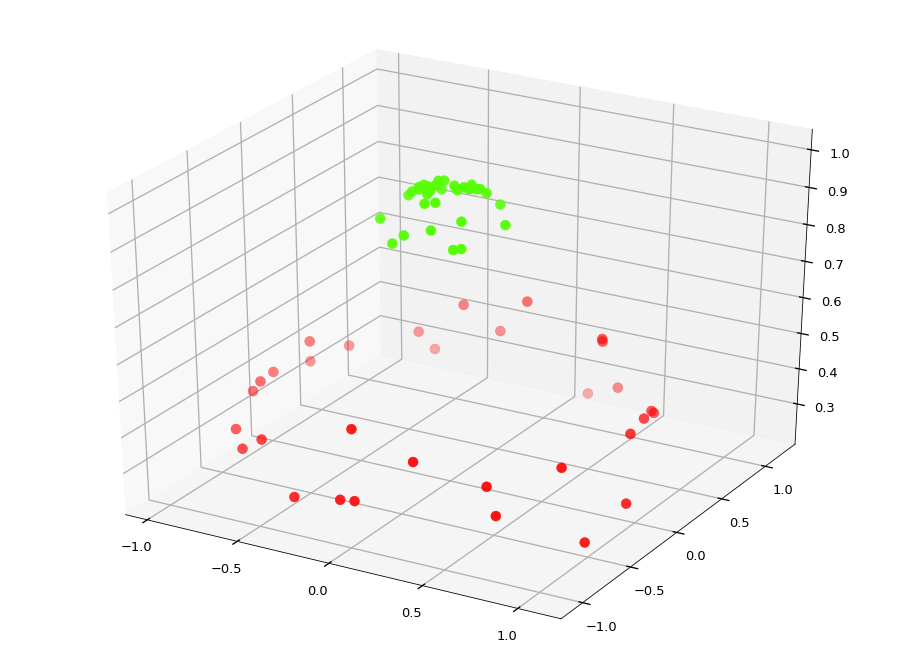

In [8]:
from mpl_toolkits import mplot3d
grbf = np.exp(-(X ** 2).sum(axis=1))
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], grbf, c=y, s=100, cmap='prism');

And it is quite easy to fit a (hyper)plane through the middle of the classes now.

## Olivetti Faces

SVMs are good for image recognition because of the high dimensional space,
i.e. one dimension per pixel in the image.
We will first attempt to classify a dataset in which faces are well centered in the images.
The Olivetti faces is a set of 400 images of faces, 10 faces per person.
It is a very clean dataset: the faces are well centered and the *support* of each class
(number of instances) is the same across all classes.

In [9]:
from sklearn.datasets import fetch_olivetti_faces
ofaces = fetch_olivetti_faces()
print(ofaces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

We should also look at the images to see what we are working with.

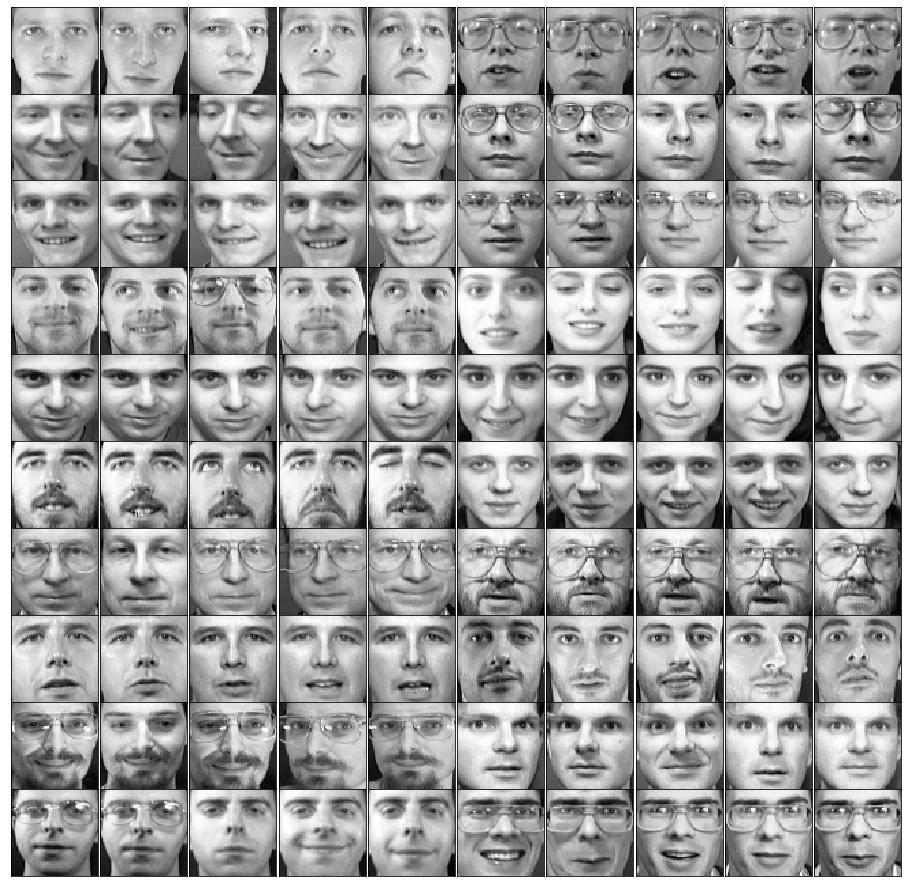

In [10]:
fig, axes = plt.subplots(10, 10, figsize=(16, 16), subplot_kw={'xticks':[], 'yticks':[]})
fig.subplots_adjust(hspace=0, wspace=0)
for i, ax in enumerate(axes.flat):
    ax.imshow(ofaces.images[i*2], cmap='binary_r')

We can certainly see what was the glasses trend in the early 1990s!

This dataset is very ordered, each person's faces (class) are next to each other.
If we will want to do cross validation we will need to shuffle it first,
that is what `sklearn.model_selection.KFold` allows us to do.

We did use `GridSearchCV` before but not with a pipeline.
With a pipeline the grid search can be given hyperparameter lists
with the name of the part of the pipeline, a double underscore and the hyperparameter name.
This is accomplished by some clever processing inside the `set_params` method,
that exists in each model (or pipeline) in `sklearn`.
The double underscore means to invoke `set_params` on the attribute named
before the double underscore, and it can be repeated when dealing with deep pipelines.

Also, the dictionary parameter to the grid search can be a list of dictionaries - as here.
This allows for different combinations when using different hyperparameters.
For example, here we try different kernels, and each requires a different set of hyperparameters.
The following will take a while to complete when run.

In [11]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
model = make_pipeline(PCA(n_components=200, svd_solver='randomized'), SVC())
strategy = KFold(n_splits=5, shuffle=True)
param_grid = [
    {'svc__kernel': ['linear'], 'svc__C': [1, 10, 100, 1000, 10000]},
    {'svc__kernel': ['rbf'], 'svc__C': [1, 10, 1000, 10000], 'svc__gamma': [0.001, 0.1, 1.0, 10.0]}
]
grid = GridSearchCV(model, param_grid, cv=strategy)
grid.fit(ofaces.data, ofaces.target)
grid.best_score_

0.975

That is a pretty good score.
SVMs are a good method for classifying images.
Let's have a look at what hyperparameters were used, throughout the entire pipeline.

In [12]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=200,
                     random_state=None, svd_solver='randomized', tol=0.0,
                     whiten=False)),
                ('svc',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

The $C$ parameter of an SVM is its tolerance to data points inside the support vectors.
A smaller $C$ results in a model with better generalization
(better at classifying unknown data) because it is less sensitive to noise in the data.
Yet, a too small $C$ will undefit the data.

That grid search took a while but it could only try a handful of values for $C$.
There is a way of performing a slightly faster search
by limiting the number of iterations whilst trying some numbers at random.
Yet, a random search cannot take different dictionaries so we will need to make do
with a single dictionary of all parameters.
Also, here we use `scipy.stats` random distributions to gather numbers from.

In [13]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
model = make_pipeline(PCA(n_components=200, svd_solver='randomized'), SVC())
strategy = KFold(n_splits=5, shuffle=True)
param_dist = {
    'svc__kernel': ['linear', 'rbf'],
    'svc__C': sp_randint(1, 100000),
    'svc__gamma': uniform(0.001, 10.0)
}
search = RandomizedSearchCV(model, param_dist, cv=strategy, n_iter=20)
search.fit(ofaces.data, ofaces.target)
search.best_score_

0.9350000000000002

This still takes a while.
Deciding between a grid search or a randomized search is a choice based on our knowledge of the data.
It is likely that the randomized search found a better $C$ value for the cross validation.

In [14]:
search.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=200,
                     random_state=None, svd_solver='randomized', tol=0.0,
                     whiten=False)),
                ('svc',
                 SVC(C=97918, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma=3.960922461843929, kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

But we cannot really know the actual generalization score for these hyperparameters.
This is because we tuned the hyperparameters against all data.

### Multicalss SVMs

Have you noticed something strange?
I just told you that an SVM draws a (hyper)plane between two classes but we just
classified 40 different classes.  What magic is happening here?

In reality we have trained 780 different SVMs, one for each pair of classes $(combination(40, 2) = 780)$.
An SVM is a **binary classifier**, i.e. it can only classify between two classes,
often called the *negative class* and the *positive class*.
What the Support Vector Classifier (`SVC`) performs is a technique called *One vs One* (OVO),
in which it trains a classifier for each pair of classes
and then runs all the classifiers to perform the prediction.

One vs All (OVA, or OVR - One vs Rest) is another technique to make
a binary classifier work on several classes.
Whilst OVO trains a classifier for each pair of classes on subsets of data,
OVA trains a classifier for each class considering it as the positive class
and all other classes as the negative class.

OVO trains more classifiers but OVA trains all classifiers on the full dataset.
For SVMs OVO is faster because an SVM takes much longer to train when the amount of data increases,
i.e. training more small SVMs is faster than a few big SVMs.

![OVO vs OVA](sl-ovo-ova.svg)

<div style="text-align:right;"><sup>sl-ovo-ova.svg</sup></div>

## Real Wold Problem

Classification issues on the Olivetti faces are hard to visualize because out classes are just numbers.
Let's use the Labeled Faces in the Wild dataset again,
since we can recognize some of the people in there by ourselves.

LFW is a much harder dataset:
the faces are in different orientations and the support of distinct classes vary considerably.
This is close to a real world problem, therefore let's treat it as such.
For a while we have been relying on cross-validation to check our models but for real world data,
where we expect to have new (previously unknown) data thrown at our classifier, this is not enough.
For this problem we will use three sets: **a training set, a validation set and a test set**.

In [15]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=50)
len(faces.data), faces.target_names

(1560,
 array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
        'Gerhard Schroeder', 'Hugo Chavez', 'Jacques Chirac',
        'Jean Chretien', 'John Ashcroft', 'Junichiro Koizumi',
        'Serena Williams', 'Tony Blair'], dtype='<U17'))

We saw this before, but just in case let's look at the images.

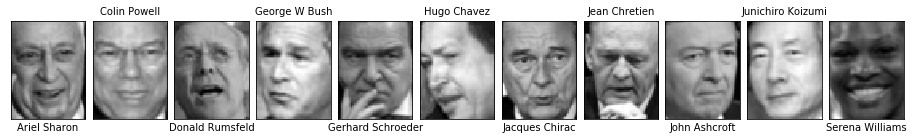

In [16]:
fig, axes = plt.subplots(1, 11, figsize=(16, 3), subplot_kw={'xticks':[], 'yticks':[]})
fig.subplots_adjust(hspace=0.1, wspace=0.1)
first_img = [np.argmax(faces.target == x) for x in list(range(len(faces.target_names)))]
for i, ax in enumerate(axes.flat):
    idx = first_img[i]
    ax.imshow(faces.data[idx].reshape(62, 47), cmap='binary_r')
    if i % 2:
        ax.set_title(faces.target_names[i], fontsize=10)
    else:
        ax.set_xlabel(faces.target_names[i], fontsize=10)

First let's flense out a test set.
We will not touch this set until we have a trained model with tuned hyperparameters.
Then we will use this set to estimate the generalization of the model against
data that it has never seen.

In [17]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(faces.data, faces.target, test_size=0.2)

Now we train the model as normal, and perform cross-validation.
We will try different kernels, let's see which kernel will perform best.
The following is still a big problem that will take a while when run.

In [18]:
model = make_pipeline(PCA(n_components=200, svd_solver='randomized'), SVC())
param_dist = {
    'svc__kernel': ['linear', 'rbf'],
    'svc__C': sp_randint(1, 100000),
    'svc__gamma': uniform(0.001, 10.0)
}
search = RandomizedSearchCV(model, param_dist, cv=5, n_iter=20)
search.fit(xtrain, ytrain)
search.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=200,
                     random_state=None, svd_solver='randomized', tol=0.0,
                     whiten=False)),
                ('svc',
                 SVC(C=6346, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma=9.621673331125944, kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

And we can see the score.

In [19]:
search.best_score_

0.7868112449799197

But plain score, be it mean accuracy or F1 does not tell us much in a multiclass problem.
Instead `sklearn` can give us the F1 - together with its components - in a classification report.
Moreover, we are really interested in how the model *generalizes*,
we should test is against the *test set* which we kept untouched until now.

In [20]:
from sklearn.metrics import classification_report
yfit = search.best_estimator_.predict(xtest)
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.79      0.73        14
     Colin Powell       0.86      0.86      0.86        56
  Donald Rumsfeld       0.50      0.67      0.57        18
    George W Bush       0.85      0.88      0.87       107
Gerhard Schroeder       0.72      0.62      0.67        21
      Hugo Chavez       0.75      0.60      0.67        10
   Jacques Chirac       0.80      0.73      0.76        11
    Jean Chretien       0.71      0.77      0.74        13
    John Ashcroft       1.00      0.57      0.73        14
Junichiro Koizumi       0.50      1.00      0.67         4
  Serena Williams       1.00      0.67      0.80        12
       Tony Blair       0.72      0.72      0.72        32

         accuracy                           0.79       312
        macro avg       0.76      0.74      0.73       312
     weighted avg       0.80      0.79      0.79       312



We have a reasonable F1 score across all classes.
There are differences where the support is poor.
But also people who tend to have a very different face from the others have a very good F1 score.
This is likely to mean that our classifier is doing what is supposed to do.
Another way of visualizing this is a confusion matrix.

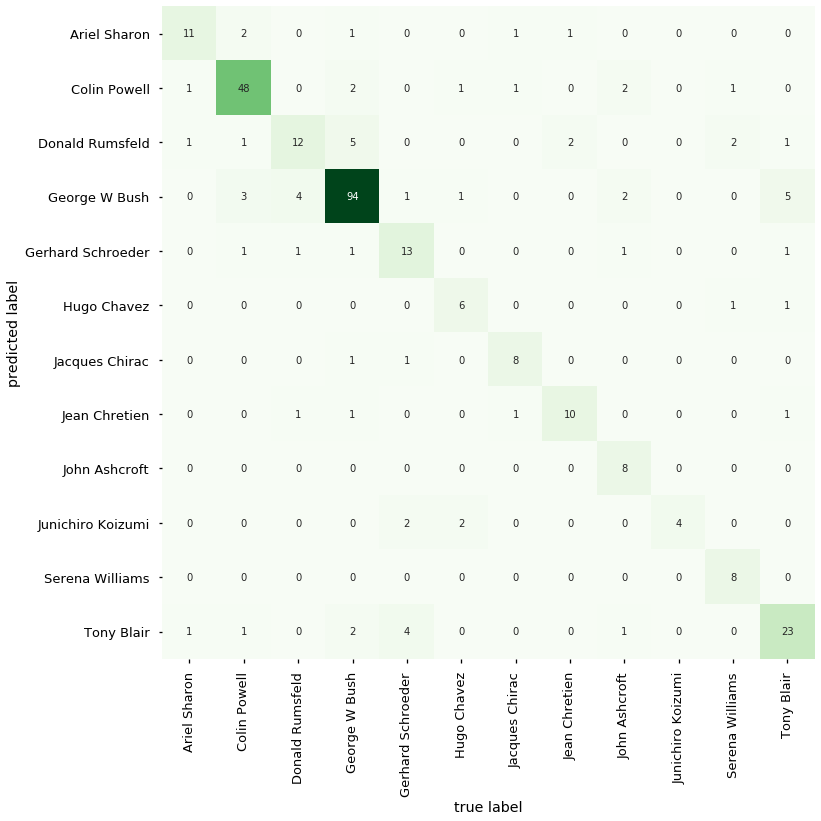

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
m = confusion_matrix(ytest, yfit)
fig = plt.figure(figsize=(12, 12))
ax = sns.heatmap(m.T, square=True, annot=True, fmt='d', cmap='Greens', cbar=False,
                 xticklabels=faces.target_names, yticklabels=faces.target_names)
ax.set(xlabel='true label', ylabel='predicted label');

That is a similar picture, we can say that the generalization is good enough.
SVMs are quite a good model for this kind of problem.

Let's see how good.
We can identify the faces on the pictures ourselves,
we can compare that against how our model did.

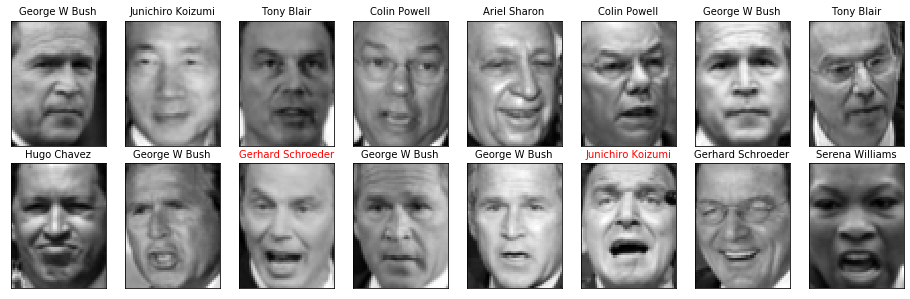

In [22]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5), subplot_kw={'xticks':[], 'yticks':[]})
fig.subplots_adjust(hspace=0.1, wspace=0.2)
correct = yfit == ytest
for i, ax in enumerate(axes.flat):
    ax.imshow(xtest[i].reshape(62, 47), cmap='binary_r')
    if correct[i]:
        ax.set_title(faces.target_names[ytest[i]], fontsize=10)
    else:
        ax.set_title(faces.target_names[yfit[i]], fontsize=10, color='red')

## References

- [sklearn - SVM margins][1]
- [sklearn - SVM kernels][2]

[1]: http://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html
[2]: http://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html